In [ ]:
# Installing packages
!pip install pyspark
!pip install neo4j
!pip install spacy
!pip install yfiles_jupyter_graphs_for_neo4j
!pip install ipywidgets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=e0aad012067fc8fa3a7a721bf8ee0e0971632cf6b0926f540be7d08e5007cc28
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/296.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextens

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, when
from neo4j import GraphDatabase
from pyspark.sql import functions as F
import plotly.graph_objects as go
import re
import difflib
import spacy
from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

In [ ]:
# Mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Big Data Project 2").getOrCreate()

In [ ]:
uri = "neo4j+s://832f0238.databases.neo4j.io"
username = "neo4j"
password = "xpEXSyitVbmG8R21qoKAdHN6j0iumt1sb7cF9B2gaTs"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [ ]:
# Creating a combined num file for 2017
num_q1 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q1/num.txt', sep='\t', header=True, inferSchema=True)
num_q2 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q2/num.txt', sep='\t', header=True, inferSchema=True)
num_q3 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q3/num.txt', sep='\t', header=True, inferSchema=True)
num_q4 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q4/num.txt', sep='\t', header=True, inferSchema=True)

df_num = num_q1.union(num_q2).union(num_q3).union(num_q4)
df_num.printSchema()
df_num.show(5)

root
 |-- adsh: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- version: string (nullable = true)
 |-- coreg: string (nullable = true)
 |-- ddate: integer (nullable = true)
 |-- qtrs: integer (nullable = true)
 |-- uom: string (nullable = true)
 |-- value: double (nullable = true)
 |-- footnote: string (nullable = true)

+--------------------+--------------------+------------+-----+--------+----+---+---------+--------+
|                adsh|                 tag|     version|coreg|   ddate|qtrs|uom|    value|footnote|
+--------------------+--------------------+------------+-----+--------+----+---+---------+--------+
|0001654954-17-000061|AccountsPayableCu...|us-gaap/2015| NULL|20141231|   0|USD| 726627.0|    NULL|
|0001654954-17-000061|AccountsPayableCu...|us-gaap/2015| NULL|20151231|   0|USD|1423503.0|    NULL|
|0001654954-17-000061|AccountsPayableCu...|us-gaap/2015| NULL|20160930|   0|USD|1851778.0|    NULL|
|0000940944-17-000002|AccountsPayableCu...|us-gaap/2015| NUL

In [ ]:
# Creating a combined pre file for 2017
pre_q1 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q1/pre.txt', sep='\t', header=True, inferSchema=True)
pre_q2 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q2/pre.txt', sep='\t', header=True, inferSchema=True)
pre_q3 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q3/pre.txt', sep='\t', header=True, inferSchema=True)
pre_q4 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q4/pre.txt', sep='\t', header=True, inferSchema=True)

df_pre = pre_q1.union(pre_q2).union(pre_q3).union(pre_q4)
df_pre.printSchema()
df_pre.show(5)

root
 |-- adsh: string (nullable = true)
 |-- report: integer (nullable = true)
 |-- line: integer (nullable = true)
 |-- stmt: string (nullable = true)
 |-- inpth: integer (nullable = true)
 |-- rfile: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- version: string (nullable = true)
 |-- plabel: string (nullable = true)
 |-- negating: integer (nullable = true)

+--------------------+------+----+----+-----+-----+--------------------+------------+----------------+--------+
|                adsh|report|line|stmt|inpth|rfile|                 tag|     version|          plabel|negating|
+--------------------+------+----+----+-----+-----+--------------------+------------+----------------+--------+
|0000009984-17-000023|     5|  18|  BS|    0|    H|AccountsPayableCu...|us-gaap/2015|Accounts payable|       0|
|0000014272-17-000047|     4|  19|  BS|    0|    H|AccountsPayableCu...|us-gaap/2015|Accounts payable|       0|
|0000016099-17-000022|     2|  18|  BS|    0|    H|Account

In [ ]:
# Creating a combined sub file for 2017
sub_q1 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q1/sub.txt', sep='\t', header=True, inferSchema=True)
sub_q2 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q2/sub.txt', sep='\t', header=True, inferSchema=True)
sub_q3 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q3/sub.txt', sep='\t', header=True, inferSchema=True)
sub_q4 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q4/sub.txt', sep='\t', header=True, inferSchema=True)

df_sub = sub_q1.union(sub_q2).union(sub_q3).union(sub_q4)
df_sub.printSchema()
df_sub.show(5)

root
 |-- adsh: string (nullable = true)
 |-- cik: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sic: integer (nullable = true)
 |-- countryba: string (nullable = true)
 |-- stprba: string (nullable = true)
 |-- cityba: string (nullable = true)
 |-- zipba: string (nullable = true)
 |-- bas1: string (nullable = true)
 |-- bas2: string (nullable = true)
 |-- baph: string (nullable = true)
 |-- countryma: string (nullable = true)
 |-- stprma: string (nullable = true)
 |-- cityma: string (nullable = true)
 |-- zipma: string (nullable = true)
 |-- mas1: string (nullable = true)
 |-- mas2: string (nullable = true)
 |-- countryinc: string (nullable = true)
 |-- stprinc: string (nullable = true)
 |-- ein: integer (nullable = true)
 |-- former: string (nullable = true)
 |-- changed: integer (nullable = true)
 |-- afs: string (nullable = true)
 |-- wksi: integer (nullable = true)
 |-- fye: integer (nullable = true)
 |-- form: string (nullable = true)
 |-- period: integer (nu

In [ ]:
# Creating a combined tag file for 2017
tag_q1 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q1/tag.txt', sep='\t', header=True, inferSchema=True)
tag_q2 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q2/tag.txt', sep='\t', header=True, inferSchema=True)
tag_q3 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q3/tag.txt', sep='\t', header=True, inferSchema=True)
tag_q4 = spark.read.csv('/content/drive/MyDrive/Project_2_Big_Data/2017q4/tag.txt', sep='\t', header=True, inferSchema=True)

df_tag = tag_q1.union(tag_q2).union(tag_q3).union(tag_q4)
df_tag.printSchema()
df_tag.show(5)

root
 |-- tag: string (nullable = true)
 |-- version: string (nullable = true)
 |-- custom: integer (nullable = true)
 |-- abstract: integer (nullable = true)
 |-- datatype: string (nullable = true)
 |-- iord: string (nullable = true)
 |-- crdr: string (nullable = true)
 |-- tlabel: string (nullable = true)
 |-- doc: string (nullable = true)

+--------------------+------------+------+--------+--------+----+----+--------------------+--------------------+
|                 tag|     version|custom|abstract|datatype|iord|crdr|              tlabel|                 doc|
+--------------------+------------+------+--------+--------+----+----+--------------------+--------------------+
|AccountsPayableCu...|us-gaap/2015|     0|       0|monetary|   I|   C|Accounts Payable,...|Carrying value as...|
|AccountsPayableRe...|us-gaap/2015|     0|       0|monetary|   I|   C|Accounts Payable,...|Amount for accoun...|
|AccountsReceivabl...|us-gaap/2015|     0|       0|monetary|   I|   D|Accounts Receivab...

#### Functions

In [ ]:
def shape(df):
    num_rows = df.count()
    num_cols = len(df.columns)
    print(f"Shape of DataFrame: ({num_rows}, {num_cols})")

In [ ]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        data = [record.data() for record in result]
        return data

#### Data Pre-Processing

In [ ]:
# Creating name dataframe
df_name = df_sub.select("adsh", "name", "sic", "countryba", "cityba")
df_name.show()
shape(df_name)

+--------------------+--------------------+----+---------+--------------+
|                adsh|                name| sic|countryba|        cityba|
+--------------------+--------------------+----+---------+--------------+
|0001213900-17-000031| KORNIT DIGITAL LTD.|3555|       IL|  ROSH-HA'AYIN|
|0001445866-17-000004|APPIPHANY TECHNOL...|7371|       CA|       KELOWNA|
|0001477932-16-014447|FRANCHISE HOLDING...|3714|       CA|       VAUGHAN|
|0001493152-17-000067|LIBERTY STAR URAN...|1000|       US|        TUCSON|
|0000886137-17-000006|FINISH LINE INC /IN/|5661|       US|  INDIANAPOLIS|
|0000899866-17-000002|ALEXION PHARMACEU...|2834|       US|     NEW HAVEN|
|0000940944-17-000002|DARDEN RESTAURANT...|5812|       US|       ORLANDO|
|0001078782-17-000006|REMSLEEP HOLDINGS...|7200|       US|WEST DESMOINES|
|0001079973-17-000010|   SERVICE TEAM INC.|7600|       US|    VILLA PARK|
|0001098009-17-000004|     CROWN MARKETING|2834|       US|      EL MONTE|
|0001171843-17-000054|BED BATH & BEYON

In [ ]:
# Creating debt dataframe
df_debt = df_pre.join(df_num, on=["adsh", "tag"], how="inner").select("adsh", "value", "plabel").filter(lower(col("plabel")).contains("debt"))
df_debt = df_debt.groupBy("adsh").agg(F.sum("value").alias("Debt"))
df_debt.show()
shape(df_debt)

+--------------------+------------+
|                adsh|        Debt|
+--------------------+------------+
|0001533526-17-000024|     5.855E8|
|0001185185-17-000094|    648507.0|
|0000016099-17-000022|    7.6954E7|
|0001569391-17-000003|  2.613691E9|
|0001391609-17-000024|    158595.0|
|0001144204-17-008493|   2214161.0|
|0001437749-17-003986|     31166.0|
|0001615774-17-001018|2.71671245E8|
|0001571049-17-001519|  5.975133E9|
|0001193125-17-078799|   5925000.0|
|0001564590-17-001559|4.9263118E10|
|0001171759-17-000012|   7.98044E8|
|0001679268-17-000006|6.99621903E8|
|0001558370-17-001627|    -57000.0|
|0001053532-17-000011|  2.551763E9|
|0001042046-17-000014|     4.894E9|
|0001213900-17-001625|      4317.0|
|0000708955-17-000016|   3.59129E8|
|0000017843-17-000006|    1.3073E9|
|0001564590-17-003421|   2.57216E8|
+--------------------+------------+
only showing top 20 rows

Shape of DataFrame: (17426, 2)


In [ ]:
# Creating revenue dataframe
df_revenue = df_num.select("adsh", "value", "tag")
df_revenue = df_revenue.filter((col("tag") == "Revenues") | (col("tag") == "SalesRevenueNet"))
df_revenues = df_revenue.groupBy("adsh").pivot("tag", ["Revenues", "SalesRevenueNet"]).agg(F.sum("value"))
df_revenues = df_revenues.withColumn(
    "TotalRevenue",
    when(col("Revenues").isNotNull(), col("Revenues"))
    .when(col("SalesRevenueNet").isNotNull(), col("SalesRevenueNet"))
    .otherwise(None)
)
df_revenues = df_revenues.drop("Revenues", "SalesRevenueNet")
df_revenues = df_revenues.withColumnRenamed("TotalRevenue", "Revenue")
df_revenues = df_revenues.dropna(subset=["Revenue"])
df_revenues.show()
shape(df_revenues)

+--------------------+-------------+
|                adsh|      Revenue|
+--------------------+-------------+
|0001193125-17-078799|   1.069033E9|
|0001391609-17-000024|          0.0|
|0001615774-17-001018| 1.15145989E8|
|0001533526-17-000024|     7.4008E9|
|0001171759-17-000012|   6.254168E9|
|0001679268-17-000006| 8.50461418E8|
|0001053532-17-000011|   3.553981E9|
|0000708955-17-000016|    1.04793E8|
|0001571049-17-001519|   6.720535E9|
|0001366744-17-000008|1.746691698E9|
|0001185185-17-000094|    5705134.0|
|0001213900-17-001625|      39367.0|
|0001193125-17-080236|        918.0|
|0001042046-17-000014|    3.3473E10|
|0001437749-17-004174|    2.00587E8|
|0001558370-17-001627|    8046000.0|
|0001437749-17-003986| 5.08014421E8|
|0000729580-17-000006|   2.621541E9|
|0001569391-17-000003|   4.389979E9|
|0001564590-17-003421|   1.123062E9|
+--------------------+-------------+
only showing top 20 rows

Shape of DataFrame: (17715, 2)


In [ ]:
# Creating a Gross Profit dataframe
df_grossprofit = df_num.select("adsh", "value", "tag")
df_grossprofit = df_grossprofit.filter((col("tag") == "Revenues") | (col("tag") == "GrossProfit") | (col("tag") == "CostOfGoodsSold") | (col("tag") == "CostOfRevenue"))
df_grossprofit = df_grossprofit.groupBy("adsh").pivot("tag", ["GrossProfit", "Revenues","CostOfGoodsSold","CostOfRevenue"]).agg(F.sum("value"))
df_grossprofit = df_grossprofit.withColumn(
    "TotalGrossProfit",
    when(col("GrossProfit").isNotNull(), col("GrossProfit"))
    .when((col("CostOfGoodsSold").isNotNull()) & (col("Revenues").isNotNull()), col("Revenues") - col("CostOfGoodsSold"))
    .when((col("CostOfRevenue").isNotNull()) & (col("Revenues").isNotNull()), col("Revenues") - col("CostOfRevenue"))
    .otherwise(None)
)
df_grossprofit = df_grossprofit.drop("GrossProfit", "Revenues","CostOfGoodsSold","CostOfRevenue")
df_grossprofit = df_grossprofit.withColumnRenamed("TotalGrossProfit", "GrossProfit")
df_grossprofit = df_grossprofit.dropna(subset=["GrossProfit"])
df_grossprofit.show()
shape(df_grossprofit)

+--------------------+------------+
|                adsh| GrossProfit|
+--------------------+------------+
|0001564590-17-000589|   9.8963E10|
|0001053532-17-000011|  1.387773E9|
|0000729580-17-000006|   5.04838E8|
|0001185185-17-000094|   1898893.0|
|0001437749-17-003986|1.54504846E8|
|0001679268-17-000006|7.81519607E8|
|0001193125-17-078799|   6.74038E8|
|0001366744-17-000008| 2.7445726E8|
|0001391609-17-000024|         0.0|
|0001533526-17-000024|     8.684E8|
|0001571049-17-001519|  2.625595E9|
|0001564590-17-003421|   4.70509E8|
|0000017843-17-000006|     3.722E8|
|0001213900-17-001625|    -61234.0|
|0001144204-17-016627|8.73143975E8|
|0001654954-17-003390|   -752039.0|
|0001078782-17-000709|    190295.0|
|0001206774-17-001612|   5.80026E8|
|0001104659-17-031254|    8.2599E7|
|0001511164-17-000218|     22005.0|
+--------------------+------------+
only showing top 20 rows

Shape of DataFrame: (11612, 2)


In [ ]:
# Creating a Net Profit dataframe
df_NetIncomeLoss = df_num.select("adsh", "value", "tag")
df_NetIncomeLoss = df_NetIncomeLoss.filter((col("tag") == "NetIncomeLoss"))
df_NetIncomeLoss = df_NetIncomeLoss.groupBy("adsh").pivot("tag", ["NetIncomeLoss"]).agg(F.sum("value"))
df_NetIncomeLoss = df_NetIncomeLoss.dropna(subset=["NetIncomeLoss"])
df_NetIncomeLoss.show()
shape(df_NetIncomeLoss)

+--------------------+-------------+
|                adsh|NetIncomeLoss|
+--------------------+-------------+
|0001193125-17-078799|    1.38815E8|
|0001391609-17-000024|   -1055781.0|
|0000016099-17-000022|   -7397000.0|
|0001571049-17-001519|    1.19646E8|
|0001558370-17-001627|    -1.9755E8|
|0001437749-17-003986|   3.381498E7|
|0001564590-17-001559|   5.478736E9|
|0001437749-17-004174|    -5.2202E7|
|0000946673-17-000003|    5.54033E8|
|0001144204-17-005491|  -3.994711E7|
|0001366744-17-000008| 2.55223394E8|
|0001569391-17-000003|   1.131806E9|
|0001193125-17-080236|      -6072.0|
|0000729580-17-000006|     -8.267E7|
|0001144204-17-017861|    1619623.0|
|0000708955-17-000016|    4.57178E8|
|0001185185-17-000094|   -1846381.0|
|0001144204-17-008493| -1.6586823E7|
|0001193125-17-082187|     4.7429E7|
|0001213900-17-001625|    -676850.0|
+--------------------+-------------+
only showing top 20 rows

Shape of DataFrame: (24259, 2)


In [ ]:
# Creating merged dataframe
df_merge = df_name.join(df_NetIncomeLoss, on="adsh", how="inner").select("adsh", "name", "sic", "countryba", "cityba", "NetIncomeLoss")
df_merge = df_merge.join(df_debt, on="adsh", how="inner").select("adsh", "name", "sic", "countryba", "cityba", "NetIncomeLoss", "Debt")
df_merge = df_merge.join(df_revenues, on="adsh", how="inner").select("adsh", "name", "sic", "countryba", "cityba", "NetIncomeLoss", "Debt",  "Revenue")
df_merge = df_merge.join(df_grossprofit, on="adsh", how="inner").select("adsh", "name", "sic", "countryba", "cityba", "Revenue", "GrossProfit", "NetIncomeLoss", "Debt")
df_merge = df_merge.dropna()
df_merge.show()
shape(df_merge)

+--------------------+--------------------+----+---------+------------------+-------------+------------+-------------+------------+
|                adsh|                name| sic|countryba|            cityba|      Revenue| GrossProfit|NetIncomeLoss|        Debt|
+--------------------+--------------------+----+---------+------------------+-------------+------------+-------------+------------+
|0001193125-17-078799|VASCO DATA SECURI...|7373|       US|  OAKBROOK TERRACE|   1.069033E9|   6.74038E8|    1.38815E8|   5925000.0|
|0001391609-17-000024|NULIFE SCIENCES, ...|7310|       US|      SAN CLEMENTE|          0.0|         0.0|   -1055781.0|    158595.0|
|0001571049-17-001519|TRAVELPORT WORLDW...|4700|       GB|LANGLEY, BERKSHIRE|   6.720535E9|  2.625595E9|    1.19646E8|  5.975133E9|
|0001437749-17-003986|     TUCOWS INC /PA/|7374|       CA|           TORONTO| 5.08014421E8|1.54504846E8|   3.381498E7|     31166.0|
|0001366744-17-000008|HOMELAND ENERGY S...|2860|       US|            LAWLER

#### Load Data into Neo4j

In [ ]:
# Function to create nodes
def company_nodes(tx, company):
    query = """
    MERGE (c:Company {adsh: $adsh, name: $name})
    """
    tx.run(query, adsh=company['adsh'],
           name=company['name'])
def financial_nodes(tx, financials):
    query = """
    MERGE (f:Financials {adsh: $adsh, revenue: $revenue, gross_profit: $gross_profit, net_income_loss: $net_income_loss, debt: $debt})
    """
    tx.run(query, adsh=financials['adsh'],
           revenue=financials['Revenue'],
           gross_profit=financials['GrossProfit'],
           net_income_loss=financials['NetIncomeLoss'],
           debt=financials['Debt'])
def location_nodes(tx, location):
    query = """
    MERGE (l:Location {city: $city, country: $country})
    """
    tx.run(query, city=location['cityba'],
           country=location['countryba'])
def sic_nodes(tx, sic):
    query = """
    MERGE (s:SIC {sic: $sic})
    """
    tx.run(query, sic=sic['sic'])
# Function to create Relaations
def company_financials_relationship(tx, row):
    query = """
    MATCH (c:Company {adsh: $adsh})
    MERGE (f:Financials {adsh: $adsh, revenue: $revenue, gross_profit: $gross_profit, net_income_loss: $net_income_loss, debt: $debt})
    MERGE (c)-[:HAS_FINANCIALS]->(f)
    """
    tx.run(query, adsh=row['adsh'],
           revenue=row['Revenue'],
           gross_profit=row['GrossProfit'],
           net_income_loss=row['NetIncomeLoss'],
           debt=row['Debt'])
def company_location_relationship(tx, row):
    query = """
    MATCH (c:Company {adsh: $adsh})
    MERGE (l:Location {city: $city, country: $country})
    MERGE (c)-[:BASED_IN]->(l)
    """
    tx.run(query, adsh=row['adsh'],
           city=row['cityba'],
           country=row['countryba'])
def company_sic_relationship(tx, row):
    query = """
    MATCH (c:Company {adsh: $adsh})
    MERGE (s:SIC {sic: $sic})
    MERGE (c)-[:CLASSIFIED_AS]->(s)
    """
    tx.run(query, adsh=row['adsh'],
           sic=row['sic'])

In [ ]:
def push_data_to_neo4j(df):
    # Collect rows from the PySpark DataFrame into a list
    rows = df.collect()

    with driver.session() as session:
        for row in rows:
            # Create Company nodes
            session.write_transaction(company_nodes, {'adsh': row.adsh, 'name': row.name})

            # Create Financial nodes
            session.write_transaction(financial_nodes, {
                'adsh': row.adsh,
                'Revenue': row.Revenue,
                'GrossProfit': row.GrossProfit,
                'NetIncomeLoss': row.NetIncomeLoss,
                'Debt': row.Debt
            })

            # Create Location nodes
            session.write_transaction(location_nodes, {
                'cityba': row.cityba,
                'countryba': row.countryba
            })

            # Create SIC nodes
            session.write_transaction(sic_nodes, {
                'sic': row.sic
            })

            # Create relationships
            session.write_transaction(company_financials_relationship, row)
            session.write_transaction(company_location_relationship, row)
            session.write_transaction(company_sic_relationship, row)

# Assuming merge_df is already defined and contains the necessary data
push_data_to_neo4j(df_merge)

# Close the driver connection
driver.close()

<ipython-input-20-728c16208c39>:8: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(company_nodes, {'adsh': row.adsh, 'name': row.name})
<ipython-input-20-728c16208c39>:11: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(financial_nodes, {
<ipython-input-20-728c16208c39>:20: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(location_nodes, {
<ipython-input-20-728c16208c39>:26: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(sic_nodes, {
<ipython-input-20-728c16208c39>:31: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(company_financials_relationship, row)
<ipython-input-20-728c16208c39>:32: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(company_location_relationship, row)
<ipython

### 1. Analyze financial statements for companies. Financial Statement Comparison allows analysts and investors to compare financial statements of different companies, aiding in benchmarking and performance evaluation.

In [ ]:
# Query to find the Net Profit Margin
driver = GraphDatabase.driver(uri, auth=(username, password))

q1_query = """
MATCH (c:Company)-[:HAS_FINANCIALS]->(f:Financials)
WITH c.name AS Company,
     SUM(f.revenue) AS TotalRevenue,
     SUM(f.net_income_loss) AS TotalNetIncomeLoss,
     SUM(f.net_income_loss) / SUM(f.revenue) * 100 AS NetProfitMargin
WHERE TotalRevenue > 0 AND TotalNetIncomeLoss > 0
RETURN Company, TotalRevenue AS Revenue, TotalNetIncomeLoss AS NetIncomeLoss, NetProfitMargin
ORDER BY NetProfitMargin DESC
"""

data_q1 = run_query(q1_query)
df_q1 = spark.createDataFrame(data_q1)
df_q1 = df_q1.select("Company", "Revenue", "NetIncomeLoss", "NetProfitMargin")
df_q1.show(truncate=False)
driver.close()

+---------------------------------------+-----------+-------------+------------------+
|Company                                |Revenue    |NetIncomeLoss|NetProfitMargin   |
+---------------------------------------+-----------+-------------+------------------+
|OXIS INTERNATIONAL INC                 |27000.0    |1.1941E7     |44225.92592592593 |
|MJP INTERNATIONAL LTD.                 |10494.0    |3336519.0    |31794.539736992567|
|ALASKA COMMUNICATIONS SYSTEMS GROUP INC|228000.0   |2.79E7       |12236.842105263158|
|IGAMBIT, INC.                          |64859.0    |6410622.0    |9883.935922539664 |
|ESCO TECHNOLOGIES INC                  |8000000.0  |2.41682E8    |3021.0249999999996|
|PREMIER BIOMEDICAL INC                 |48552.0    |866555.0     |1784.7977426264624|
|INEEDMD HOLDINGS, INC.                 |12306.0    |182993.0     |1487.0225906062083|
|FONAR CORP                             |1.2001E7   |1.09425897E8 |911.8064911257395 |
|NOTIS GLOBAL, INC.                     |13

<ipython-input-20-963fd6205ec2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_pdf_q1, x='Company', y='NetProfitMargin', palette='viridis')


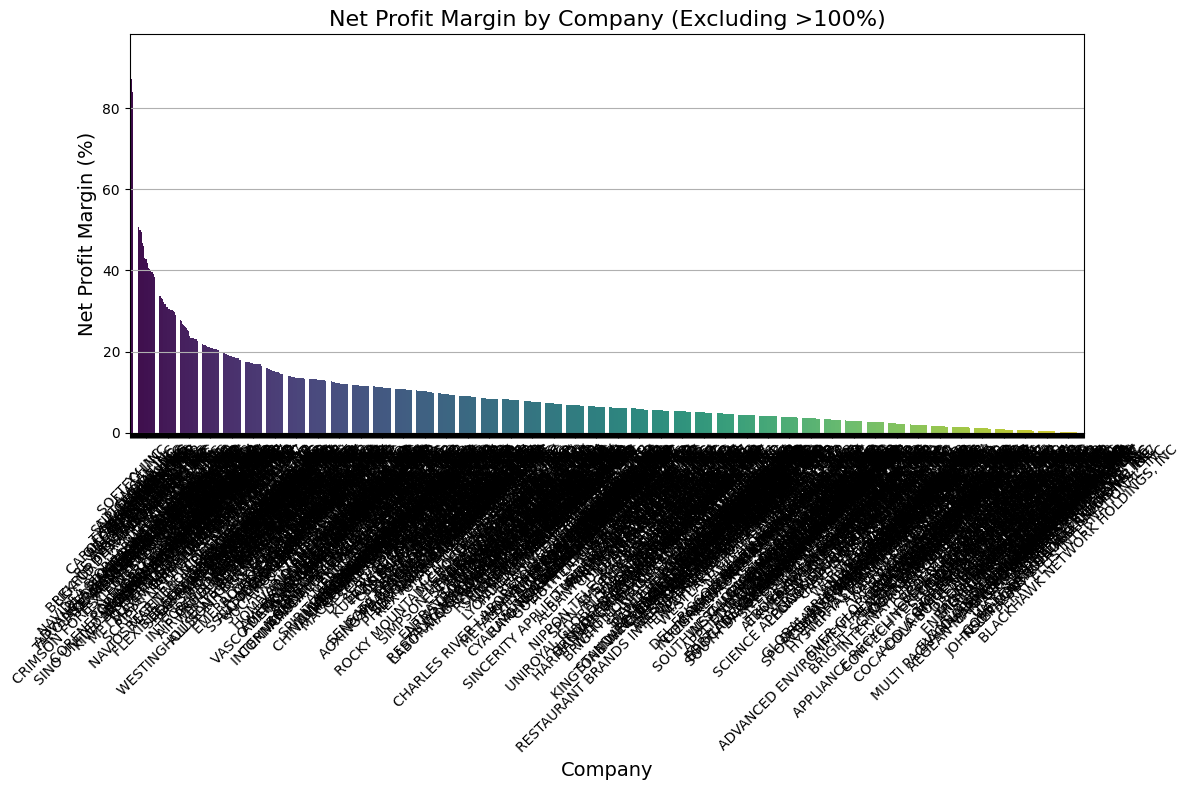

In [ ]:
# Plotting Net Profit Margin
pdf_q1 = df_q1.toPandas()

filtered_pdf_q1 = pdf_q1[pdf_q1['NetProfitMargin'] <= 100]
plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_pdf_q1, x='Company', y='NetProfitMargin', palette='viridis')
plt.title('Net Profit Margin by Company (Excluding >100%)', fontsize=16)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Net Profit Margin (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The provided data was extracted from financial statements and analyzed to calculate net profit margins for various companies. Companies with net profit margins exceeding 100% were excluded, as they are likely outliers or errors in the data.

The analysis reveals a wide range of profit margins among the remaining companies. Most companies have net profit margins above 30%, indicating strong profitability within their respective industries. However, a more comprehensive analysis would require additional information such as industry comparisons and financial ratios to understand the underlying drivers of profitability and potential risks.

#### 2. Cluster companies based on financial health. Financial health is a function of revenue and debt, i.e. a health company will have high revenue and low debt.

In [ ]:
# Query to find the companies Financial Health
driver = GraphDatabase.driver(uri, auth=(username, password))

q2_query = """
MATCH (c:Company)-[:HAS_FINANCIALS]->(f:Financials)
WITH c.name AS Company,
     SUM(f.revenue) AS TotalRevenue,
     SUM(f.debt) AS TotalDebt
WHERE TotalDebt > 0 AND TotalRevenue > 0
WITH Company, TotalRevenue, TotalDebt,
     (TotalDebt / TotalRevenue) * 100 AS DTR,
     CASE
         WHEN TotalRevenue < 0 THEN 'Poor Financial Health'
         WHEN TotalDebt / TotalRevenue > 0.43 THEN 'Poor Financial Health'
         WHEN TotalDebt / TotalRevenue >= 0.36 AND TotalDebt / TotalRevenue <= 0.43 THEN 'Moderate Financial Health'
         WHEN TotalDebt / TotalRevenue < 0.36 THEN 'Good Financial Health'
         ELSE 'Undefined'
     END AS FinancialHealth
RETURN Company, TotalRevenue AS Revenue, TotalDebt AS Debt, DTR, FinancialHealth
ORDER BY DTR ASC
"""

data_q2 = run_query(q2_query)
df_q2 = spark.createDataFrame(data_q2)
df_q2 = df_q2.select("Company", "Revenue", "Debt", "DTR", "FinancialHealth")
df_q2.show(truncate=False)
driver.close()

+---------------------------------+-------------+------------------+---------------------+---------------------+
|Company                          |Revenue      |Debt              |DTR                  |FinancialHealth      |
+---------------------------------+-------------+------------------+---------------------+---------------------+
|ROSETTA GENOMICS LTD.            |4.3899E7     |18.0              |4.100321191826693E-5 |Good Financial Health|
|DSWISS INC                       |693495.0     |2.1               |3.0281400731079535E-4|Good Financial Health|
|RITO GROUP CORP.                 |261537.0     |1.2000000000000002|4.5882609343993403E-4|Good Financial Health|
|NUTRI SYSTEM INC /DE/            |2.419203E9   |24000.0           |9.920622618275522E-4 |Good Financial Health|
|GOLDEN GRAIN ENERGY              |1.270605106E9|13114.0           |0.0010321066661918483|Good Financial Health|
|WD 40 CO                         |2.647091E9   |43000.0           |0.001624424698659774 |Good F

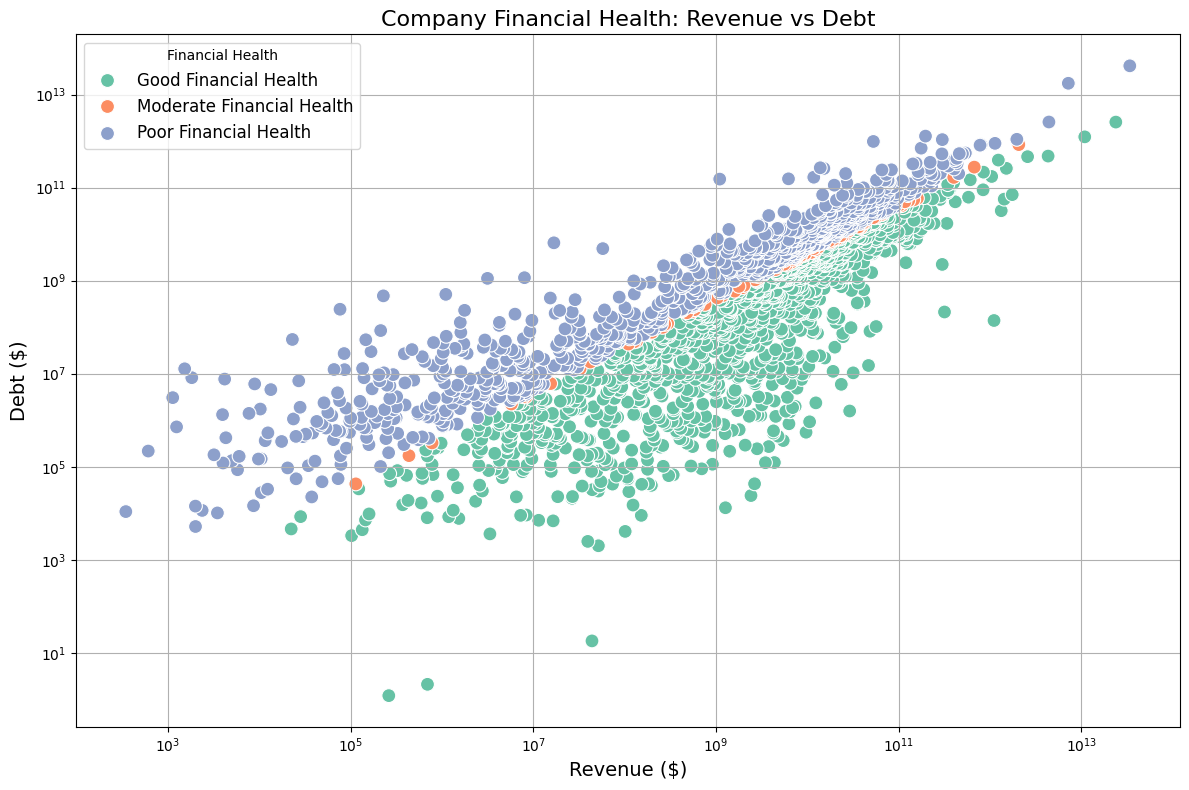

In [ ]:
# Plotting Financial Health
pdf_q2 = df_q2.toPandas()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pdf_q2, x='Revenue', y='Debt', hue='FinancialHealth', palette='Set2', s=100)
plt.title('Company Financial Health: Revenue vs Debt', fontsize=16)
plt.xlabel('Revenue ($)', fontsize=14)
plt.ylabel('Debt ($)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Financial Health', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

The code provided analyzed the financial health of various companies based on their total revenue and total debt. A financial health score (DTR) was calculated for each company by dividing its total debt by total revenue. Companies were then categorized into three groups: "Good Financial Health" (DTR < 0.36), "Moderate Financial Health" (0.36 <= DTR <= 0.43), and "Poor Financial Health" (DTR > 0.43). Additionally, companies with negative total revenue were automatically categorized as "Poor Financial Health." This categorization provides a simple and effective way to assess a company's financial health using only two key financial metrics. However, a more comprehensive analysis would require additional financial metrics to provide a deeper understanding of each company's financial standing.

#### 3.Identify unusual reporting patterns or significant deviations from historical data, which may indicate potential fraud or misrepresentation.


In [ ]:
# Query to find the outliers
driver = GraphDatabase.driver(uri, auth=(username, password))

q3_query = """
MATCH (c:Company)-[:HAS_FINANCIALS]->(f:Financials)
WITH c.name AS Company,
     SUM(f.revenue) AS TotalRevenue,
     SUM(f.gross_profit) AS TotalGrossProfit,
     SUM(f.net_income_loss) AS TotalNetIncomeLoss,
     SUM(f.debt) AS TotalDebt
WHERE TotalRevenue < 0 OR
      TotalDebt < 0 OR
      TotalRevenue < TotalGrossProfit OR
      TotalRevenue < TotalNetIncomeLoss OR
      TotalGrossProfit < TotalNetIncomeLoss
RETURN Company, TotalRevenue AS Revenue, TotalGrossProfit AS GrossProfit,
       TotalNetIncomeLoss AS NetIncomeLoss, TotalDebt AS Debt
ORDER BY Company
"""

data_q3 = run_query(q3_query)

df_q3 = spark.createDataFrame(data_q3)

df_q3 = df_q3.select("Company", "Revenue", "GrossProfit", "NetIncomeLoss", "Debt")

df_q3.show(truncate=False)

shape(df_q3)

driver.close()

+---------------------------------------+-----------+-----------+-------------+------------+
|Company                                |Revenue    |GrossProfit|NetIncomeLoss|Debt        |
+---------------------------------------+-----------+-----------+-------------+------------+
|ACTIVECARE, INC.                       |2.8861438E7|7569907.0  |-6.1250545E7 |-4.3869597E7|
|ADVANCED ENERGY INDUSTRIES INC         |8.26497E8  |1.128094E9 |-1.5082E7    |5967000.0   |
|AG&E HOLDINGS INC.                     |7.8851E7   |2.1768E7   |-1.5247E7    |-7000.0     |
|AIM EXPLORATION INC.                   |0.0        |0.0        |-6931640.0   |-1332000.0  |
|AIRMEDIA GROUP INC.                    |1.4341E8   |-9.3788E7  |5.8327E7     |1.3248E7    |
|AKERS BIOSCIENCES, INC.                |6137679.0  |4017389.0  |-6268767.0   |-2599218.0  |
|ALASKA COMMUNICATIONS SYSTEMS GROUP INC|228000.0   |4.90846E8  |2.79E7       |4.70684E8   |
|ALIMERA SCIENCES INC                   |2.46738E8  |2.28606E8  |-1.75


The query was designed to identify unusual financial reporting patterns by detecting outliers in the SEC filings data. It flagged companies with negative revenue or debt, or where revenue was less than gross profit or net income. Additionally, cases where gross profit was less than net income were identified as potential anomalies. The result was a DataFrame with 178 rows and 5 columns, showing the company names alongside their total revenue, gross profit, net income loss, and debt. These results highlight significant deviations from typical financial trends, which may indicate potential issues such as misreporting or errors.

####  5. Financial Query and Report Generation via GraphRAG. The user should be able to query specific financial metrics, trends, or insights from the dataset using plain English.


In [ ]:
# Creating GraphRAG
class CompanyGraph:
    def __init__(self, driver):
        self.driver = driver
        self.nlp = spacy.load("en_core_web_md")
    def retrieve_company_data(self, tx, company_name):
        query = """
        MATCH (c:Company)-[:HAS_FINANCIALS]->(f:Financials),
              (c)-[:BASED_IN]->(l:Location),
              (c)-[:CLASSIFIED_AS]->(s:SIC)
        WHERE toLower(c.name) CONTAINS toLower($company_name)
        RETURN c.name AS company_name, f.revenue AS revenue,
               f.gross_profit AS gross_profit,
               f.net_income_loss AS net_income_loss,
               f.debt AS debt, l.city AS city,
               l.country AS country, s.sic AS sic
        """
        result = tx.run(query, company_name=company_name)
        return result.single()
    def generate_report_for_company(self, company_name):
        with self.driver.session() as session:
            company_data = session.execute_read(self.retrieve_company_data, company_name)
            if company_data:
                report = self.format_report(company_data)
                return report
            else:
                return f"No data found for company: {company_name}"
    def format_report(self, company_data):
        company_name = company_data['company_name']
        revenue = company_data['revenue']
        gross_profit = company_data['gross_profit']
        net_income_loss = company_data['net_income_loss']
        debt = company_data['debt']
        city = company_data['city']
        country = company_data['country']
        sic = company_data['sic']
        report = f"""
        Company Report for {company_name}
        Location: {city}, {country}
        SIC: {sic}
        Financials:
        - Revenue: ${revenue}
        - Gross Profit: ${gross_profit}
        - Net Income/Loss: ${net_income_loss}
        - Debt: ${debt}
        """
        return report

    def extract_company_name(self, user_input):
        doc = self.nlp(user_input)
        company_names = []
        for ent in doc.ents:
            print(f"Entity: {ent.text}, Label: {ent.label_}")
            if ent.label_ == "ORG":
                company_names.append(ent.text)
        return company_names[0] if company_names else None

# Usage
if __name__ == "__main__":
    driver = GraphDatabase.driver(uri, auth=(username, password))
    company_graph = CompanyGraph(driver)
    while True:
        user_input = input("Please enter the name of the company you want to retrieve the financial report for (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break
        company_name = company_graph.extract_company_name(user_input)
        if company_name:
            report = company_graph.generate_report_for_company(company_name)
            print(report)
        else:
            company_name = user_input.strip()
            report = company_graph.generate_report_for_company(company_name)
            print(report if report else "No company name detected. Please try again.")
    driver.close()

Please enter the name of the company you want to retrieve the financial report for (or type 'exit' to quit): I want the financial information of nippon
Entity: nippon, Label: ORG

        Company Report for NIPPON TELEGRAPH & TELEPHONE CORP
        Location: TOKYO JAPAN, JP
        SIC: 4813
        Financials:
        - Revenue: $34027330000000.0
        - Gross Profit: $31228224000000.0
        - Net Income/Loss: $2055933000000.0
        - Debt: $41464415000000.0
        
Please enter the name of the company you want to retrieve the financial report for (or type 'exit' to quit): the financial information of nippon
Entity: nippon, Label: ORG

        Company Report for NIPPON TELEGRAPH & TELEPHONE CORP
        Location: TOKYO JAPAN, JP
        SIC: 4813
        Financials:
        - Revenue: $34027330000000.0
        - Gross Profit: $31228224000000.0
        - Net Income/Loss: $2055933000000.0
        - Debt: $41464415000000.0
        
Please enter the name of the company you want to 


The financial query and report generation system using GraphRAG allows users to retrieve company financial data through plain English queries. It integrates Neo4j to store company relationships, financial data, location, and SIC codes. Spacy's NLP model extracts company names from user input, which are then used to query the database for specific financial metrics like revenue, gross profit, net income/loss, and debt. The system formats this information into a readable financial report.

Several challenges were encountered during the development. Attempts to use free versions of ChatGPT API and Gemini API for generating Cypher queries were unsuccessful, requiring an upgrade for full functionality. Transformers such as T5 and ChatGPT models, along with Hugging Face Cypher transformers, were tested for generating queries but were unable to produce accurate Cypher syntax.